## Classification task

### Libraries

In [1]:
import pandas as pd
import torch
import numpy as np
import dice_ml

from functools import partial
from torch import nn 
from classification_code.Classification import (
    analyze_class_imbalance, balance_dataset, main_classifier, final_train_classifier,
    compare_capping_methods, cap_outliers_IQR, NNClassifier
)
from classification_code.Autoencoder import Autoencoder
from classification_code.utils import OurDataset
from classification_code.xai import analyze_model


### Dataset preparation

In [5]:
train_dataset_path = "dataset_classification/TrainDataset.csv"

numerical_features = ['length', 'climb_total', 'profile', 'startlist_quality', 'cyclist_age', 'delta']
def bin_points(df):
    bins = [0, 1, 5, 10, 20, 50, 100, float('inf')]
    labels = ['None', 'Very Low', 'Low', 'Medium', 'High', 'Very High', 'Exceptional']
    merged_points = np.ceil((df['uci_points'] * 0.5 + df['points'] * 0.5))
    df['points_category'] = pd.cut(merged_points, bins=bins, labels=labels, include_lowest=True)
    df = df.drop(columns=['uci_points', 'points'])

    return df

train_dataset = OurDataset(train_dataset_path, apply_transformers=True, call_on_df_funcs=[bin_points])

train_dataset.data.sample(5)


,length,climb_total,profile,startlist_quality,cyclist_age,delta,points_category_High,points_category_Low,points_category_Medium,points_category_None,points_category_Very High,points_category_Very Low
560862,0.288169,-0.130450,-1.183073,1.011797,-1.429034,1.656308,0.0,0.0,0.0,1.0,0.0,0.0
214532,-0.080809,0.070146,-0.451282,-0.542935,1.459139,-0.703762,0.0,0.0,0.0,1.0,0.0,0.0
462257,0.849323,-0.076650,-0.451282,1.022302,-0.641350,-0.443788,0.0,0.0,0.0,1.0,0.0,0.0
437955,-0.011626,-1.101151,-1.183073,-0.311826,-1.166473,1.109334,0.0,0.0,0.0,1.0,0.0,0.0
296764,0.956942,-0.332584,-0.451282,1.326946,1.196578,-0.643910,0.0,0.0,0.0,1.0,0.0,0.0


### Exploring the classes imbalance

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Class Distribution:
Class 1.0: 86602 samples (15.41%)
Class 0.0: 475369 samples (84.59%)

Imbalance Ratio: 5.49


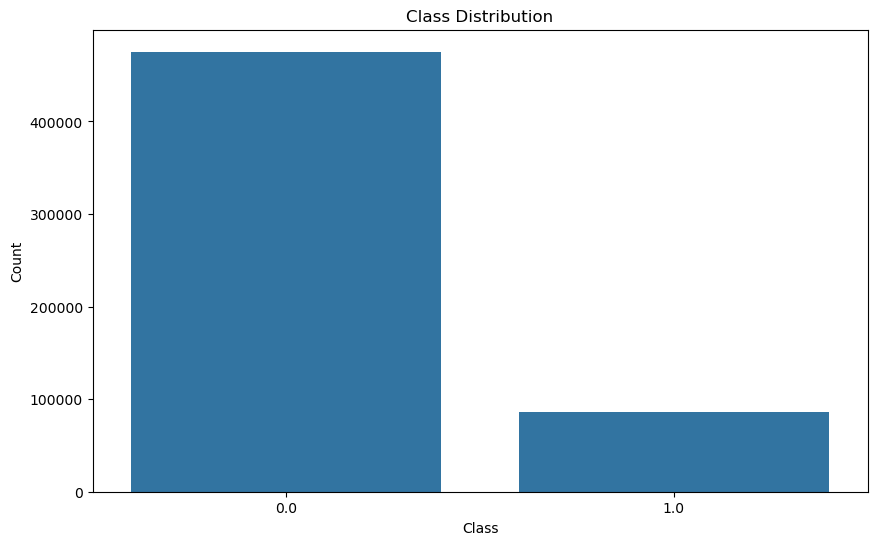

(Counter({0.0: 475369, 1.0: 86602}), 5.489122653056511)

In [6]:
train_labels = train_dataset.labels

analyze_class_imbalance(train_labels)


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Class Distribution:
Class 1.0: 475369 samples (50.00%)
Class 0.0: 475369 samples (50.00%)

Imbalance Ratio: 1.00


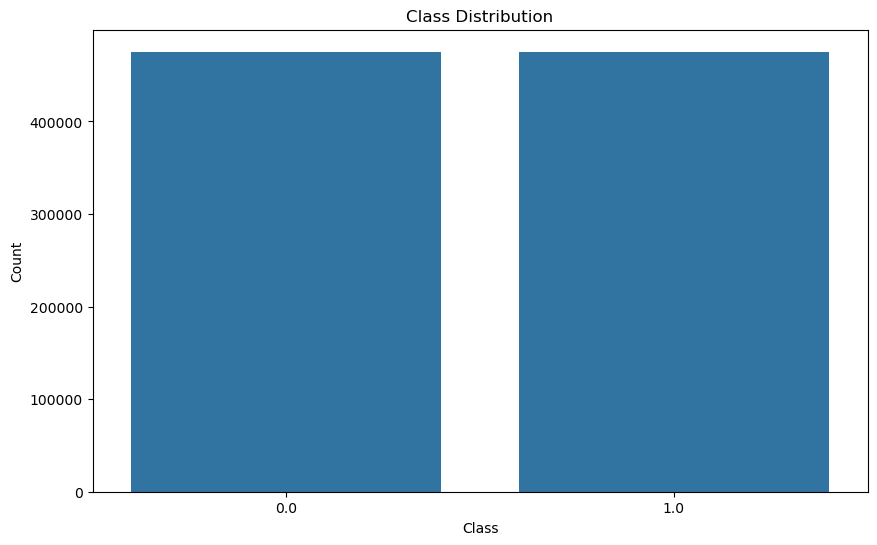

In [7]:
# balanced_dataset_path = "DatasetClassification/BalancedTrainDataset.csv"

balanced_dataset, y_balanced = balance_dataset(train_dataset.data, train_labels, method="smote")
# y_balanced.rename('label', inplace=True)
# concat_dataset = balanced_dataset.join(y_balanced)

# concat_dataset.to_csv(balanced_dataset_path, index=False)
train_dataset.update_data(balanced_dataset, y_balanced)

analyze_class_imbalance(y_balanced)
del balanced_dataset, y_balanced


In [8]:
results, capped_percentages = compare_capping_methods(train_dataset.data[numerical_features])

print("Original Data Statistics:")
print(train_dataset.data[numerical_features].agg(['min', 'max', 'mean', 'std']).round(3))
print("\nPercentage of values capped by each method:")
for method, percentage in capped_percentages.items():
    print(f"{method}: {percentage}% of values capped")

Original Data Statistics:
      length  climb_total  profile  startlist_quality  cyclist_age   delta
min   -2.556       -1.804   -1.183             -2.605       -7.468  -0.728
max    2.625        3.554    1.744              2.469        4.347  16.777
mean   0.000        0.024    0.025             -0.092       -0.033   0.209
std    1.016        0.994    0.973              1.005        0.967   1.083

Percentage of values capped by each method:
Conservative (2.0 IQR): 1.91% of values capped
Standard (1.5 IQR): 2.99% of values capped
Aggressive (1.0 IQR): 6.18% of values capped
Z-score (3 std): 0.07% of values capped
Z-score (2.5 std): 0.44% of values capped
Z-score (2 std): 3.94% of values capped


In [9]:
train_dataset.apply_on_df(partial(cap_outliers_IQR, multiplier=2.0), features_to_apply=numerical_features) # Cap outliers using IQR method with a multiplier of 2.0 (conservative)

print(train_dataset.data[numerical_features].agg(['min', 'max', 'mean', 'std']).round(3))


length:
Lower Bound: -1.841
Upper Bound: 2.195

climb_total:
Lower Bound: -3.431
Upper Bound: 3.475

profile:
Lower Bound: -3.378
Upper Bound: 3.939

startlist_quality:
Lower Bound: -2.967
Upper Bound: 2.574

cyclist_age:
Lower Bound: -3.612
Upper Bound: 3.527

delta:
Lower Bound: -4.586
Upper Bound: 5.151
      length  climb_total  profile  startlist_quality  cyclist_age  delta
min   -1.841       -1.804   -1.183             -2.605       -3.612 -0.728
max    2.195        3.475    1.744              2.469        3.527  5.151
mean   0.049        0.024    0.025             -0.092       -0.033  0.208
std    0.907        0.994    0.973              1.005        0.966  1.071


### Training the classifier

In [8]:
main_classifier(
    data=train_dataset.to_tensor(), labels=train_dataset.label_tensor,
    num_samples=10, max_num_epochs=20
)

2025-01-05 01:09:39,548	INFO worker.py:1821 -- Started a local Ray instance.
2025-01-05 01:09:40,256	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-05 01:09:40,267	ERROR tune_controller.py:235 -- Failed to restore the run state.
Traceback (most recent call last):
  File "/home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/ray/tune/execution/tune_controller.py", line 230, in __init__
    self.resume(resume_config=resume_config)
  File "/home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/ray/tune/execution/tune_controller.py", line 437, in resume
    raise ValueError(
ValueError: Tried to resume experiment from directory '/home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/ray_classifier/cycling_classifier', but no experiment state file of the form 'experiment_state-{}.json' was found. This is expected if you are launching a new experiment.
2025-01-05 01:09:40,268	INFO tune_controller.py:238 -- Restarting experiment.
(raylet) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(raylet) I0000 00:00:1736035781.129295 1244489 cht

(func pid=1246478) Fold 1


(func pid=1246478) GPU available: True (cuda), used: True
(func pid=1246478) TPU available: False, using: 0 TPU cores
(func pid=1246478) HPU available: False, using: 0 HPUs
(func pid=1246478) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246478) 
(func pid=1246478)   | Name          | Type              | Params | Mode 
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246478) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246478) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246478) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246478) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246478) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 3.1 K     Trainable params
(func pid=1246478) 0  

(func pid=1246479) Fold 2 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(func pid=1246479) `Trainer.fit` stopped: `max_epochs=20` reached.
(func pid=1246477) GPU available: True (cuda), used: True [repeated 3x across cluster]
(func pid=1246477) TPU available: False, using: 0 TPU cores [repeated 3x across cluster]
(func pid=1246477) HPU available: False, using: 0 HPUs [repeated 3x across cluster]
(func pid=1246477) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0] [repeated 3x across cluster]
(func pid=1246477)   | Name          | Type              | Params | Mode  [repeated 3x across cluster]
(func pid=1246477) ------------------------------------------------------------ [repeated 6x across cluster]
(func pid=1246477) 0 | loss_function | BCEWithLogitsLoss | 0      | train [repeated 3x across cluster]
(func pid=1246479) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246477) 2 | train_acc     | BinaryAccuracy    | 0      | train [repeated 3x across cluster]
(func pid=1246477) 3 | val_acc       | BinaryAccuracy    | 0      | train [repeated 3x acro

(func pid=1246476) Fold 2


(func pid=1246476) /home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/cls_logs/fold_2/202501050109/checkpoints exists and is not empty.
(func pid=1246476) 
(func pid=1246476) 1 | model         | Sequential        | 401    | train
(func pid=1246476) 401       Trainable params
(func pid=1246476) 401       Total params
(func pid=1246476) GPU available: True (cuda), used: True [repeated 2x across cluster]
(func pid=1246476) TPU available: False, using: 0 TPU cores [repeated 2x across cluster]
(func pid=1246476) HPU available: False, using: 0 HPUs [repeated 2x across cluster]
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0] [repeated 2x across cluster]
(func pid=1246476)   | Name          | Type              | Params | Mode  [repeated 2x across cluster]
(func pid=1246476) ------------------------------

(func pid=1246478) Fold 2


(func pid=1246478) 
(func pid=1246478) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246478) 3.1 K     Trainable params
(func pid=1246478) 3.1 K     Total params
(func pid=1246478) /home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/cls_logs/fold_2/202501050109/checkpoints exists and is not empty.
(func pid=1246478) GPU available: True (cuda), used: True
(func pid=1246478) TPU available: False, using: 0 TPU cores
(func pid=1246478) HPU available: False, using: 0 HPUs
(func pid=1246478) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246478)   | Name          | Type              | Params | Mode 
(func pid=1246478) ------------------------------------------------------------ [repeated 2x across cluster]
(func pid=1246478) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1

(func pid=1246479) Fold 3


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 3.1 K     Trainable params
(func pid=1246479) 0  

(func pid=1246479) Fold 4


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 3.1 K     Trainable params
(func pid=1246479) 0  

(func pid=1246477) Fold 2


(func pid=1246477) /home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/cls_logs/fold_2/202501050109/checkpoints exists and is not empty.
(func pid=1246477) 
(func pid=1246477) 1 | model         | Sequential        | 401    | train
(func pid=1246477) 401       Trainable params
(func pid=1246477) 401       Total params
(func pid=1246477) GPU available: True (cuda), used: True
(func pid=1246477) TPU available: False, using: 0 TPU cores
(func pid=1246477) HPU available: False, using: 0 HPUs
(func pid=1246477) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246477)   | Name          | Type              | Params | Mode 
(func pid=1246477) ------------------------------------------------------------ [repeated 2x across cluster]
(func pid=1246477) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1

(func pid=1246478) Fold 3
(func pid=1246476) Fold 3


(func pid=1246476) /home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/cls_logs/fold_3/202501050109/checkpoints exists and is not empty.
(func pid=1246476) 
(func pid=1246476) 1 | model         | Sequential        | 401    | train
(func pid=1246476) 401       Trainable params
(func pid=1246476) 401       Total params
(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------ [repeated 2x across cluster]
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1

(func pid=1246479) Fold 5


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 3.1 K     Trainable params
(func pid=1246479) 0  

(func pid=1246478) Fold 4


(func pid=1246478) /home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/cls_logs/fold_4/202501050109/checkpoints exists and is not empty.
(func pid=1246478) 
(func pid=1246478) GPU available: True (cuda), used: True
(func pid=1246478) TPU available: False, using: 0 TPU cores
(func pid=1246478) HPU available: False, using: 0 HPUs
(func pid=1246478) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246478)   | Name          | Type              | Params | Mode 
(func pid=1246478) ------------------------------------------------------------ [repeated 2x across cluster]
(func pid=1246478) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246478) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246478) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246478) 3 | va

Trial name,combined_metrics,should_checkpoint,val_auroc,val_f1,val_loss
train_classifier_wrapper_5b80d_00000,0.668594,True,0.922571,0.746213,0.331595
train_classifier_wrapper_5b80d_00001,0.675667,True,0.926317,0.751268,0.326251
train_classifier_wrapper_5b80d_00002,0.624142,True,0.900604,0.716978,0.369298
train_classifier_wrapper_5b80d_00003,0.656856,True,0.916015,0.743663,0.345965
train_classifier_wrapper_5b80d_00004,0.657043,True,0.916754,0.743549,0.346217
train_classifier_wrapper_5b80d_00005,0.636499,True,0.910899,0.711443,0.349344
train_classifier_wrapper_5b80d_00006,0.616435,True,0.899951,0.705451,0.372533
train_classifier_wrapper_5b80d_00007,0.60883,True,0.889523,0.715794,0.387657
train_classifier_wrapper_5b80d_00008,0.663192,True,0.923376,0.734896,0.331887
train_classifier_wrapper_5b80d_00009,0.694572,True,0.939323,0.750685,0.300863


2025-01-05 02:07:04,457	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'act_fn': ('__ref_ph', '6f662850'), 'optimizer': ('__ref_ph', '46a9caad')}
(func pid=1246479) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/ray_classifier/cycling_classifier/train_classifier_wrapper_5b80d_00000_0_act_fn=ref_ph_6f662850,batch_size=128,lr=0.0007,weight_decay=0.0000,dropout=0.1169,hidden_d_2025-01-05_01-09-40/checkpoint_000000)


(func pid=1246479) Fold 1


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 5.4 K     Trainable params
(func pid=1246479) 0  

(func pid=1246476) Fold 4


(func pid=1246476) /home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/cls_logs/fold_4/202501050109/checkpoints exists and is not empty.
(func pid=1246476) 
(func pid=1246476) 1 | model         | Sequential        | 401    | train
(func pid=1246476) 401       Trainable params
(func pid=1246476) 401       Total params
(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------ [repeated 2x across cluster]
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1

(func pid=1246478) Fold 5


(func pid=1246478) GPU available: True (cuda), used: True
(func pid=1246478) TPU available: False, using: 0 TPU cores
(func pid=1246478) HPU available: False, using: 0 HPUs
(func pid=1246478) /home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/cls_logs/fold_5/202501050109/checkpoints exists and is not empty.
(func pid=1246478) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246478) 
(func pid=1246478)   | Name          | Type              | Params | Mode 
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246478) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246478) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246478) 3 | val_acc       | BinaryAccuracy 

(func pid=1246479) Fold 2


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 5.4 K     Trainable params
(func pid=1246479) 0  

(func pid=1246477) Fold 3


(func pid=1246477) /home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/cls_logs/fold_3/202501050109/checkpoints exists and is not empty.
(func pid=1246477) 
(func pid=1246477) 1 | model         | Sequential        | 401    | train
(func pid=1246477) 401       Trainable params
(func pid=1246477) 401       Total params
(func pid=1246477) GPU available: True (cuda), used: True
(func pid=1246477) TPU available: False, using: 0 TPU cores
(func pid=1246477) HPU available: False, using: 0 HPUs
(func pid=1246477) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246477)   | Name          | Type              | Params | Mode 
(func pid=1246477) ------------------------------------------------------------ [repeated 2x across cluster]
(func pid=1246477) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1

(func pid=1246476) Fold 5


(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476) 
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246476) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246476) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246476) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246476) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246476) 0         Non-trainable params
(func pid=1246476) 0.002     Total estimated model params size (MB)
(func pid=1246476) 14        Modules in train mode
(func pid=1246476) 0         Modules in eval mode
(func pid=1246476) /home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/

(func pid=1246479) Fold 3


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 5.4 K     Trainable params
(func pid=1246479) 0  

(func pid=1246476) Fold 1


(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476) 
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246476) 1 | model         | Sequential        | 1.0 K  | train
(func pid=1246476) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246476) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246476) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246476) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 1.0 K     Trainable params
(func pid=1246476) 0  

(func pid=1246478) Fold 1


(func pid=1246478) GPU available: True (cuda), used: True
(func pid=1246478) TPU available: False, using: 0 TPU cores
(func pid=1246478) HPU available: False, using: 0 HPUs
(func pid=1246478) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246478) 
(func pid=1246478)   | Name          | Type              | Params | Mode 
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246478) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246478) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246478) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246478) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246478) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 3.1 K     Trainable params
(func pid=1246478) 0  

(func pid=1246477) Fold 4


(func pid=1246477) /home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/cls_logs/fold_4/202501050109/checkpoints exists and is not empty.
(func pid=1246477) GPU available: True (cuda), used: True
(func pid=1246477) TPU available: False, using: 0 TPU cores
(func pid=1246477) HPU available: False, using: 0 HPUs
(func pid=1246477) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246477) 
(func pid=1246477)   | Name          | Type              | Params | Mode 
(func pid=1246477) ------------------------------------------------------------
(func pid=1246477) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246477) 1 | model         | Sequential        | 401    | train
(func pid=1246477) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246477) 3 | val_acc       | BinaryAccuracy 

(func pid=1246476) Fold 2


(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476) 
(func pid=1246476) 1 | model         | Sequential        | 1.0 K  | train
(func pid=1246476) 1.0 K     Trainable params
(func pid=1246476) 1.0 K     Total params
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------ [repeated 2x across cluster]
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246476) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246476) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246476) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246476) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246476) 0         No

(func pid=1246479) Fold 4


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 5.4 K     Trainable params
(func pid=1246479) 0  

(func pid=1246476) Fold 3


(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476) 
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246476) 1 | model         | Sequential        | 1.0 K  | train
(func pid=1246476) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246476) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246476) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246476) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 1.0 K     Trainable params
(func pid=1246476) 0  

(func pid=1246479) Fold 5


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 5.4 K     Trainable params
(func pid=1246479) 0  

(func pid=1246478) Fold 2


(func pid=1246478) GPU available: True (cuda), used: True
(func pid=1246478) TPU available: False, using: 0 TPU cores
(func pid=1246478) HPU available: False, using: 0 HPUs
(func pid=1246478) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246478) 
(func pid=1246478)   | Name          | Type              | Params | Mode 
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246478) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246478) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246478) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246478) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246478) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 3.1 K     Trainable params
(func pid=1246478) 0  

(func pid=1246476) Fold 4


(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476) 
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246476) 1 | model         | Sequential        | 1.0 K  | train
(func pid=1246476) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246476) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246476) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246476) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 1.0 K     Trainable params
(func pid=1246476) 0  

(func pid=1246477) Fold 5


(func pid=1246477) /home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/cls_logs/fold_5/202501050109/checkpoints exists and is not empty.
(func pid=1246477) 
(func pid=1246477) 1 | model         | Sequential        | 401    | train
(func pid=1246477) 401       Trainable params
(func pid=1246477) 401       Total params
(func pid=1246477) GPU available: True (cuda), used: True
(func pid=1246477) TPU available: False, using: 0 TPU cores
(func pid=1246477) HPU available: False, using: 0 HPUs
(func pid=1246477) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246477)   | Name          | Type              | Params | Mode 
(func pid=1246477) ------------------------------------------------------------ [repeated 2x across cluster]
(func pid=1246477) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1

(func pid=1246479) Fold 1


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 513    | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 513       Trainable params
(func pid=1246479) 0  

(func pid=1246476) Fold 5


(func pid=1246476) 
(func pid=1246476) 1 | model         | Sequential        | 1.0 K  | train
(func pid=1246476) 1.0 K     Trainable params
(func pid=1246476) 1.0 K     Total params
(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------ [repeated 2x across cluster]
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246476) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246476) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246476) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246476) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246476) 0         No

(func pid=1246476) Fold 1


(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476) 
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246476) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246476) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246476) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246476) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246476) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 5.4 K     Trainable params
(func pid=1246476) 0  

(func pid=1246478) Fold 3


(func pid=1246478) GPU available: True (cuda), used: True
(func pid=1246478) TPU available: False, using: 0 TPU cores
(func pid=1246478) HPU available: False, using: 0 HPUs
(func pid=1246478) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246478) 
(func pid=1246478)   | Name          | Type              | Params | Mode 
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246478) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246478) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246478) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246478) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246478) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 3.1 K     Trainable params
(func pid=1246478) 0  

(func pid=1246476) Fold 2


(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476) 
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246476) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246476) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246476) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246476) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246476) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 5.4 K     Trainable params
(func pid=1246476) 0  

(func pid=1246479) Fold 2


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 513    | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 513       Trainable params
(func pid=1246479) 0  

(func pid=1246477) Fold 1


(func pid=1246477) GPU available: True (cuda), used: True
(func pid=1246477) TPU available: False, using: 0 TPU cores
(func pid=1246477) HPU available: False, using: 0 HPUs
(func pid=1246477) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246477) 
(func pid=1246477)   | Name          | Type              | Params | Mode 
(func pid=1246477) ------------------------------------------------------------
(func pid=1246477) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246477) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246477) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246477) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246477) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246477) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246477) ------------------------------------------------------------
(func pid=1246477) 5.4 K     Trainable params
(func pid=1246477) 0  

(func pid=1246476) Fold 3


(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476) 
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246476) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246476) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246476) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246476) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246476) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 5.4 K     Trainable params
(func pid=1246476) 0  

(func pid=1246477) Fold 2


(func pid=1246477) GPU available: True (cuda), used: True
(func pid=1246477) TPU available: False, using: 0 TPU cores
(func pid=1246477) HPU available: False, using: 0 HPUs
(func pid=1246477) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246477) 
(func pid=1246477)   | Name          | Type              | Params | Mode 
(func pid=1246477) ------------------------------------------------------------
(func pid=1246477) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246477) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246477) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246477) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246477) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246477) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246477) ------------------------------------------------------------
(func pid=1246477) 5.4 K     Trainable params
(func pid=1246477) 0  

(func pid=1246477) Fold 3


(func pid=1246477) GPU available: True (cuda), used: True
(func pid=1246477) TPU available: False, using: 0 TPU cores
(func pid=1246477) HPU available: False, using: 0 HPUs
(func pid=1246477) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246477) 
(func pid=1246477)   | Name          | Type              | Params | Mode 
(func pid=1246477) ------------------------------------------------------------
(func pid=1246477) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246477) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246477) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246477) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246477) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246477) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246477) ------------------------------------------------------------
(func pid=1246477) 5.4 K     Trainable params
(func pid=1246477) 0  

(func pid=1246477) Fold 4


(func pid=1246477) GPU available: True (cuda), used: True
(func pid=1246477) TPU available: False, using: 0 TPU cores
(func pid=1246477) HPU available: False, using: 0 HPUs
(func pid=1246477) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246477) 
(func pid=1246477)   | Name          | Type              | Params | Mode 
(func pid=1246477) ------------------------------------------------------------
(func pid=1246477) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246477) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246477) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246477) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246477) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246477) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246477) ------------------------------------------------------------
(func pid=1246477) 5.4 K     Trainable params
(func pid=1246477) 0  

(func pid=1246477) Fold 5


(func pid=1246477) GPU available: True (cuda), used: True
(func pid=1246477) TPU available: False, using: 0 TPU cores
(func pid=1246477) HPU available: False, using: 0 HPUs
(func pid=1246477) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246477) 
(func pid=1246477)   | Name          | Type              | Params | Mode 
(func pid=1246477) ------------------------------------------------------------
(func pid=1246477) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246477) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246477) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246477) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246477) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246477) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246477) ------------------------------------------------------------
(func pid=1246477) 5.4 K     Trainable params
(func pid=1246477) 0  

(func pid=1246478) Fold 4


(func pid=1246478) GPU available: True (cuda), used: True
(func pid=1246478) TPU available: False, using: 0 TPU cores
(func pid=1246478) HPU available: False, using: 0 HPUs
(func pid=1246478) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246478) 
(func pid=1246478)   | Name          | Type              | Params | Mode 
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246478) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246478) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246478) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246478) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246478) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 3.1 K     Trainable params
(func pid=1246478) 0  

(func pid=1246476) Fold 4


(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476) 
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246476) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246476) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246476) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246476) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246476) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 5.4 K     Trainable params
(func pid=1246476) 0  

(func pid=1246479) Fold 3


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 513    | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 513       Trainable params
(func pid=1246479) 0  

(func pid=1246476) Fold 5


(func pid=1246476) GPU available: True (cuda), used: True
(func pid=1246476) TPU available: False, using: 0 TPU cores
(func pid=1246476) HPU available: False, using: 0 HPUs
(func pid=1246476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246476) 
(func pid=1246476)   | Name          | Type              | Params | Mode 
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246476) 1 | model         | Sequential        | 5.4 K  | train
(func pid=1246476) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246476) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246476) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246476) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246476) ------------------------------------------------------------
(func pid=1246476) 5.4 K     Trainable params
(func pid=1246476) 0  

(func pid=1246478) Fold 5


(func pid=1246478) GPU available: True (cuda), used: True
(func pid=1246478) TPU available: False, using: 0 TPU cores
(func pid=1246478) HPU available: False, using: 0 HPUs
(func pid=1246478) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246478) 
(func pid=1246478)   | Name          | Type              | Params | Mode 
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246478) 1 | model         | Sequential        | 3.1 K  | train
(func pid=1246478) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246478) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246478) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246478) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246478) ------------------------------------------------------------
(func pid=1246478) 3.1 K     Trainable params
(func pid=1246478) 0  

(func pid=1246479) Fold 4


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 513    | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 513       Trainable params
(func pid=1246479) 0  

(func pid=1246479) Fold 5


(func pid=1246479) GPU available: True (cuda), used: True
(func pid=1246479) TPU available: False, using: 0 TPU cores
(func pid=1246479) HPU available: False, using: 0 HPUs
(func pid=1246479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(func pid=1246479) 
(func pid=1246479)   | Name          | Type              | Params | Mode 
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 0 | loss_function | BCEWithLogitsLoss | 0      | train
(func pid=1246479) 1 | model         | Sequential        | 513    | train
(func pid=1246479) 2 | train_acc     | BinaryAccuracy    | 0      | train
(func pid=1246479) 3 | val_acc       | BinaryAccuracy    | 0      | train
(func pid=1246479) 4 | f1_score      | BinaryF1Score     | 0      | train
(func pid=1246479) 5 | auroc         | BinaryAUROC       | 0      | train
(func pid=1246479) ------------------------------------------------------------
(func pid=1246479) 513       Trainable params
(func pid=1246479) 0  

Best trial config: {'hidden_dims': [32, 96, 16], 'batch_size': 128, 'act_fn': LeakyReLU(negative_slope=0.01), 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'dropout': 0.07780308171101662, 'config_optimizer': {'weight_decay': 0.00010954871639140185, 'lr': 0.009565510925024952}}
Best combined metrics: 0.6945723384618758
Best validation loss: 0.3008629739284515
Best validation F1: 0.7506848931312561
Best validation AUROC: 0.9393227577209473
Best checkpoint path: Checkpoint(filesystem=local, path=/home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/ray_classifier/cycling_classifier/train_classifier_wrapper_5b80d_00009_9_act_fn=ref_ph_65afb126,batch_size=128,lr=0.0096,weight_decay=0.0001,dropout=0.0778,hidden_d_2025-01-05_01-09-40/checkpoint_000000)


I0000 00:00:1736049425.275317 1244270 chttp2_transport.cc:1182] ipv4:192.168.133.243:64851: Got goaway [2] err=UNAVAILABLE:GOAWAY received; Error code: 2; Debug Text: Cancelling all calls {created_time:"2025-01-05T04:57:05.27530639+01:00", http2_error:2, grpc_status:14}


(train_classifier_wrapper_5b80d_00009,
 {'hidden_dims': [32, 96, 16],
  'batch_size': 128,
  'act_fn': LeakyReLU(negative_slope=0.01),
  'optimizer': torch.optim.adamw.AdamW,
  'dropout': 0.07780308171101662,
  'config_optimizer': {'weight_decay': 0.00010954871639140185,
   'lr': 0.009565510925024952}},
 Checkpoint(filesystem=local, path=/home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/ray_classifier/cycling_classifier/train_classifier_wrapper_5b80d_00009_9_act_fn=ref_ph_65afb126,batch_size=128,lr=0.0096,weight_decay=0.0001,dropout=0.0778,hidden_d_2025-01-05_01-09-40/checkpoint_000000))

In [10]:

data = train_dataset.to_tensor()
y = train_dataset.label_tensor

config = {
    "input_dim": data.shape[1],
    "hidden_dims": [32, 128, 16],
    "batch_size": 128,
    "act_fn": nn.LeakyReLU(negative_slope=0.15),
    "optimizer": torch.optim.AdamW,
    "dropout": 0.3,
    "monitor": "train_loss",
    "max_epochs": 40,
    "model_save_path": "models/classifier",
}

trainer_config = {
    "accelerator": "gpu",
    "devices": 1,
    "strategy": "auto",
    "precision": 32,
    "enable_progress_bar": True,
}
optimizer_params = {
    "lr": 0.01,
    "weight_decay": 0.00011,
}


config["optimizer_params"] = optimizer_params
config["trainer_config"] = trainer_config

classifier = final_train_classifier(data, y, **config)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | loss_function | BCEWithLogitsLoss | 0      | train
1 | model         | Sequential        | 7.1 K  | train
2 | train_acc     | BinaryAccuracy    | 0      | train
3 | val_acc       | BinaryAccuracy    | 0      | train
4 | f1_score      | BinaryF1Score     | 0      | train
5 | auroc         | BinaryAUROC       | 0      | train
------------------------------------------------------------
7.1 K     Trainable params
0         Non-trainable params
7.1 K     Total params
0.028     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


Creating the folders for the model: /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/classifier, if they do not exist.
With the model name: NNClassifier_20250105050134
Saving the model to: /home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/classifier/NNClassifier_20250105050134


In [14]:
import torchmetrics

test_dataset_path = "dataset_classification/TestDataset.csv"
test_dataset = OurDataset(test_dataset_path, apply_transformers=True, call_on_df_funcs=[bin_points])
test_dataset.apply_on_df(partial(cap_outliers_IQR, multiplier=2.0), features_to_apply=numerical_features) # Cap outliers using IQR method with a multiplier of 2.0 (conservative)

print(train_dataset.data[numerical_features].agg(['min', 'max', 'mean', 'std']).round(3))

test_data = test_dataset.to_tensor()
test_y = test_dataset.label_tensor

classifier.eval()
with torch.no_grad():
    test_pred = classifier(test_data)
    test_pred = torch.sigmoid(test_pred).round().squeeze()

test_acc = torchmetrics.Accuracy(task='binary', num_classes=2)
val_acc = torchmetrics.Accuracy(task='binary', num_classes=2)
f1_score = torchmetrics.F1Score(task='binary', num_classes=2)
auroc = torchmetrics.AUROC(task='binary', num_classes=2)

print(f"Test Accuracy: {test_acc(test_pred, test_y)}")
print(f"Test F1 Score: {f1_score(test_pred, test_y)}")
print(f"Test AUROC: {auroc(test_pred, test_y)}")



length:
Lower Bound: -1.560
Upper Bound: 1.904

climb_total:
Lower Bound: -3.547
Upper Bound: 3.602

profile:
Lower Bound: -3.231
Upper Bound: 3.615

startlist_quality:
Lower Bound: -2.262
Upper Bound: 2.011

cyclist_age:
Lower Bound: -3.968
Upper Bound: 3.848

delta:
Lower Bound: -3.045
Upper Bound: 2.916
      length  climb_total  profile  startlist_quality  cyclist_age  delta
min   -1.847       -1.804   -1.183             -2.605       -3.606 -0.728
max    2.198        3.482    1.744              2.469        3.523  5.142
mean   0.048        0.024    0.026             -0.094       -0.032  0.206
std    0.908        0.994    0.974              1.004        0.967  1.070
Test Accuracy: 0.9332297444343567
Test F1 Score: 0.7297884225845337
Test AUROC: 0.8259502649307251


INFO:classification_code.xai:Generating SHAP explanations...


  0%|          | 0/1600 [00:00<?, ?it/s]

INFO:classification_code.xai:Setting up LIME explainer...
INFO:classification_code.xai:Data interface: <dice_ml.data_interfaces.public_data_interface.PublicData object at 0x7884a673cb00>
INFO:classification_code.xai:Initializing DiCE explainer...
100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


UserConfigValidationException: No counterfactuals found for any of the query points! Kindly check your configuration.

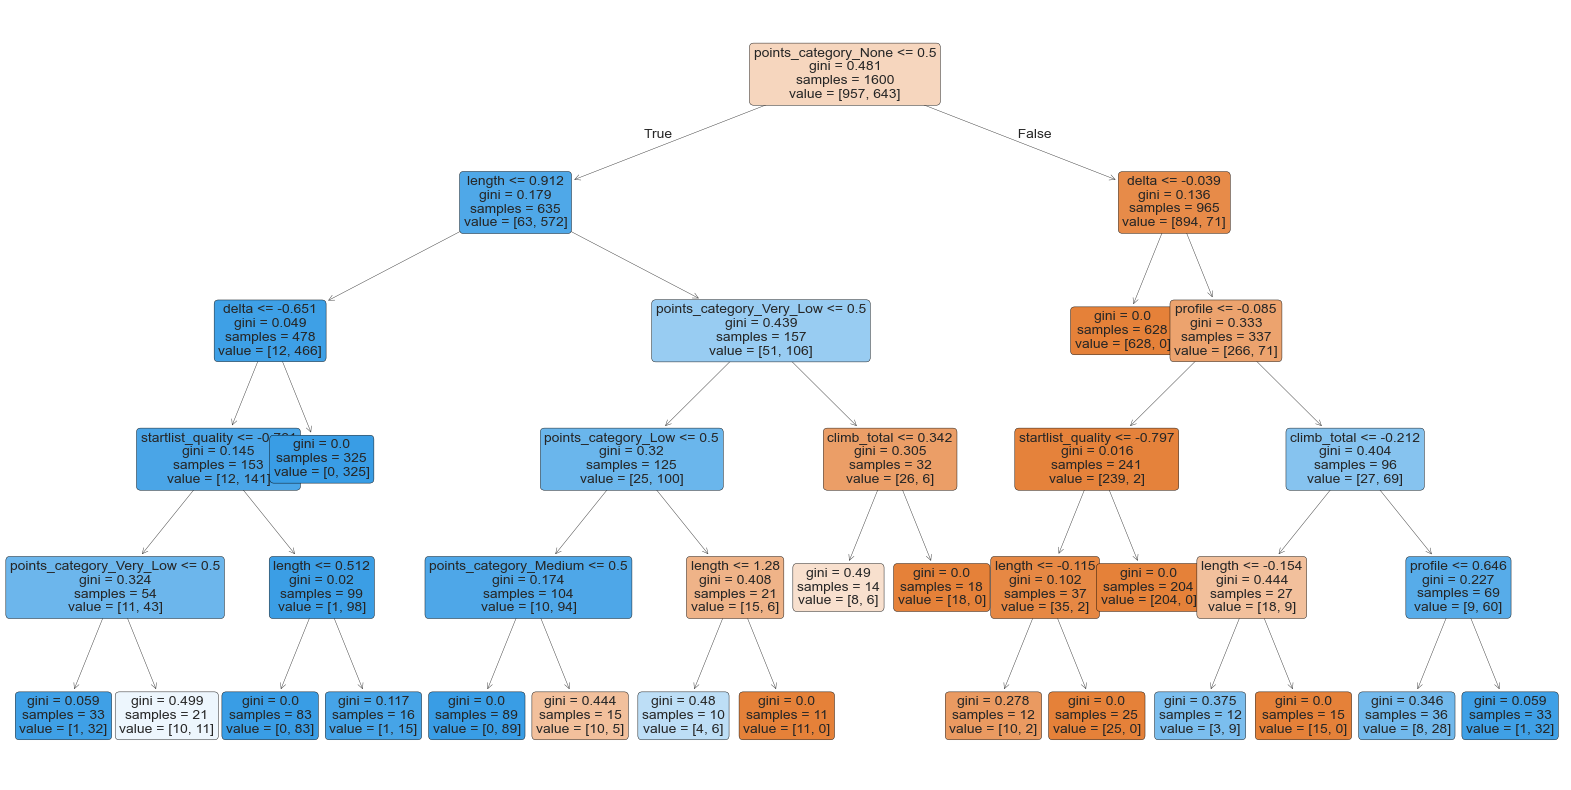

<Figure size 1200x800 with 0 Axes>

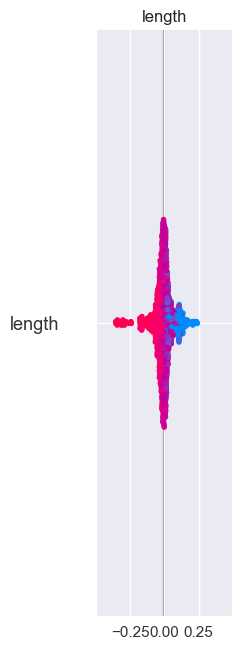

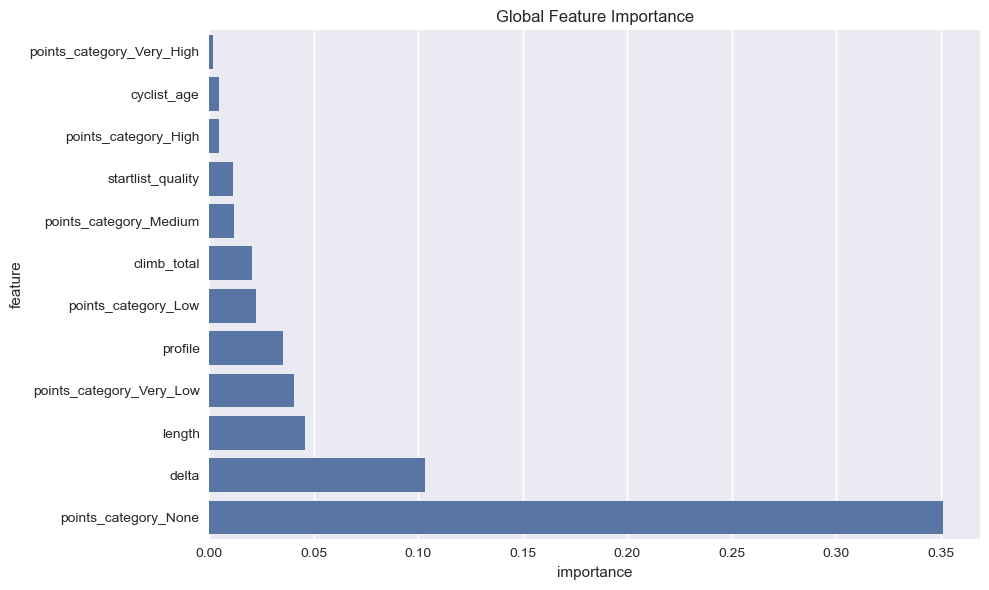

<Figure size 1000x600 with 0 Axes>

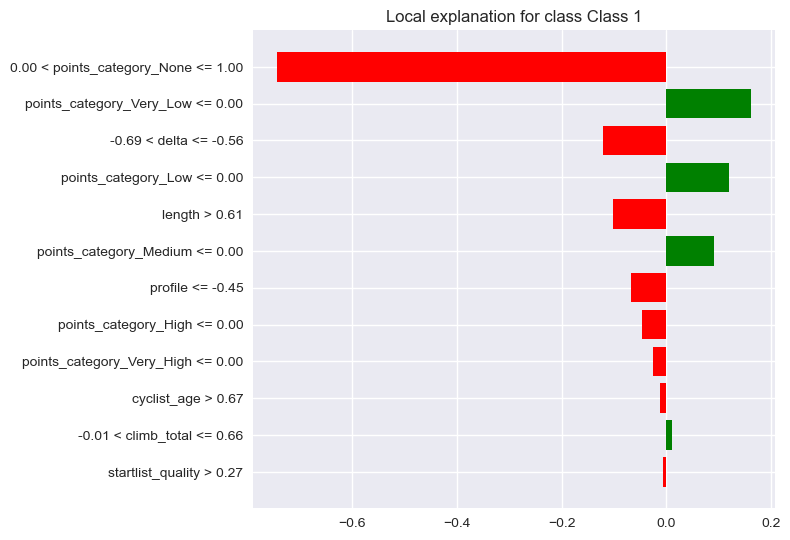

In [2]:
import warnings

from classification_code.Classification import NNClassifier

warnings.filterwarnings("ignore", category=FutureWarning)
state_dict = torch.load("/home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/classifier/NNClassifier_20250105050134", weights_only=True)

def bin_points(df):
    bins = [0, 1, 5, 10, 20, 50, 100, float('inf')]
    labels = ['None', 'Very_Low', 'Low', 'Medium', 'High', 'Very_High', 'Exceptional']
    merged_points = np.ceil((df['uci_points'] * 0.5 + df['points'] * 0.5))
    df['points_category'] = pd.cut(merged_points, bins=bins, labels=labels, include_lowest=True)
    df = df.drop(columns=['uci_points', 'points'])

    return df
train_dataset_path = "dataset_classification/TrainDataset.csv"
test_dataset_path = "dataset_classification/TestDataset.csv"
numerical_features = ['length', 'climb_total', 'profile', 'startlist_quality', 'cyclist_age', 'delta']


train_dataset = OurDataset(train_dataset_path, apply_transformers=True, call_on_df_funcs=[bin_points])
train_labels = train_dataset.labels
test_dataset = OurDataset(test_dataset_path, apply_transformers=True, call_on_df_funcs=[bin_points])

balanced_dataset, y_balanced = balance_dataset(train_dataset.data, train_labels, method="smote")

train_dataset.update_data(balanced_dataset, y_balanced)

train_dataset.apply_on_df(partial(cap_outliers_IQR, multiplier=2.0), features_to_apply=numerical_features) # Cap outliers using IQR method with a multiplier of 2.0 (conservative)
test_dataset.apply_on_df(partial(cap_outliers_IQR, multiplier=2.0), features_to_apply=numerical_features)

config_local = {
    "input_dim": train_dataset.shape[1],
    "hidden_dims": [32, 128, 16],
    "act_fn": nn.LeakyReLU(negative_slope=0.15),
    "optimizer": torch.optim.AdamW,
    "dropout": 0.3,
}

model = NNClassifier(**config_local)
model.load_state_dict(state_dict)
num_samples_train = 1600 // 2
num_samples_test = 1600 // 2

train_class_1 = train_dataset.data[train_dataset.labels == 1]
train_class_2 = train_dataset.data[train_dataset.labels == 0]
train_sample_1 = train_class_1.sample(n=num_samples_train)
train_sample_2 = train_class_2.sample(n=num_samples_train)
X_train = pd.concat([train_sample_1, train_sample_2]).values.astype(np.float32)

test_class_1 = test_dataset.data[test_dataset.labels == 1]
test_class_2 = test_dataset.data[test_dataset.labels == 0]
test_sample_1 = test_class_1.sample(n=num_samples_test)
test_sample_2 = test_class_2.sample(n=num_samples_test)
X_test = pd.concat([test_sample_1, test_sample_2]).values.astype(np.float32)

feature_names=train_dataset.data.columns

model.eval()
with torch.no_grad():
    predictions = (torch.sigmoid(model(torch.from_numpy(X_train)) > 0.5)).int()



continuous_features = [
    'length', 
    'climb_total',
    'profile',
    'startlist_quality',
    'cyclist_age',
    'delta'
]


dice_df = pd.DataFrame(X_train, columns=feature_names)
dice_df['prediction'] = pd.Series(predictions.squeeze().numpy())
encoded_categories = [col for col in dice_df.columns if col.startswith('points_category_')]

d = dice_ml.Data(
    dataframe=dice_df,
    continuous_features=continuous_features,
    categorical_features=['points_category'],
    outcome_name='prediction',
    features_to_vary=continuous_features + ['points_category'],
    permitted_range={
        col: [0, 1] for col in encoded_categories  # Binary range for one-hot encoded features
    }
)

analyze_model(
    model=model, X_train=X_train, X_test=X_test, 
    feature_names=train_dataset.data.columns, save_dir="models/xai_results",
    data_interface=d
)